# Transfer Learning with Tensorflow Part 3 : Scaling up
Goal is to beat the original  Food101 paper with 10% of the training.

In [1]:
!nvidia-smi

Tue Feb 14 20:15:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8     4W /  50W |    810MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [1]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

## 101food classes working with less data
Goal is to beat original Food101 paper

In [2]:
unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning with 10 % of 101 food classes
Steps we're going to take:
* Create Modelcheckpoint callback
* Create data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0
* Compile our model
* Feature extract for 5 full passes

In [6]:
#create checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True
                                                      )

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [8]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
input_shape=(224,224,3)
# Create input layer
inputs=layers.Input(shape=input_shape,name="Input layer")

# Add in data augmentation model as a laywer
x=data_augmentation(inputs)

#Give base model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)

#Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="Pooling_layer")(x)

#Put a dense layer as on output
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

#Make a model using inputs and outputs
model=tf.keras.Model(inputs,outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [10]:
#Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"] 
             )

In [11]:
#Fit model for 5 epochs
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback]
                                        )

Epoch 1/5
237/237 [==============================] - 148s 575ms/step - loss: 3.3513 - accuracy: 0.2789 - val_loss: 2.5683 - val_accuracy: 0.4216
Epoch 2/5
237/237 [==============================] - 106s 445ms/step - loss: 2.1889 - accuracy: 0.4982 - val_loss: 2.0628 - val_accuracy: 0.5050
Epoch 3/5
237/237 [==============================] - 94s 398ms/step - loss: 1.8275 - accuracy: 0.5597 - val_loss: 1.9294 - val_accuracy: 0.5140
Epoch 4/5
237/237 [==============================] - 85s 360ms/step - loss: 1.6032 - accuracy: 0.6070 - val_loss: 1.8113 - val_accuracy: 0.5426
Epoch 5/5
237/237 [==============================] - 83s 350ms/step - loss: 1.4390 - accuracy: 0.6482 - val_loss: 1.7811 - val_accuracy: 0.5384


In [12]:
#Evaluate on whole test dataset
fine_tuning_results=model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 89s 113ms/step - loss: 1.5842 - accuracy: 0.5846


[1.5842069387435913, 0.5845544338226318]

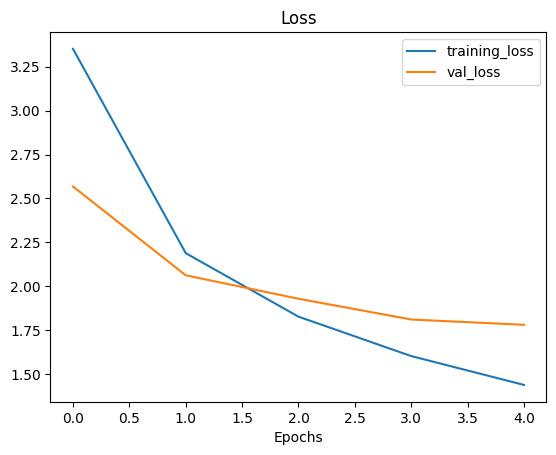

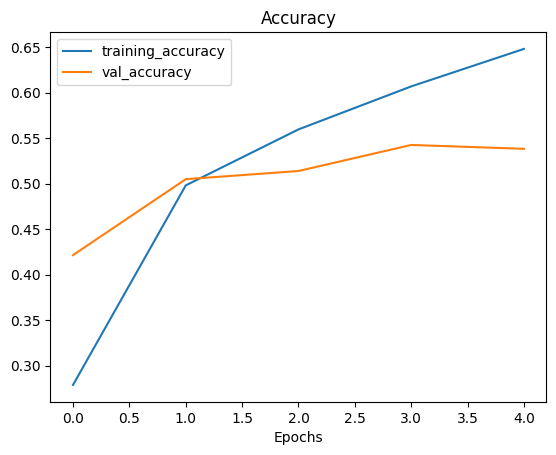

In [13]:
plot_loss_curves(history_all_classes_10_percent)

### Model is overfitting 

## Fine Tuning

In [14]:
#Unfreeze all layers in base model
base_model.trainable=True

#Refreeze except last 5

for layers in base_model.layers[:-5]:
    layers.trainable=False


In [15]:
# Recomplie model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"]
             )

In [16]:
 for layer in model.layers:
        print(f"{layer.name}, {layer.trainable}")

Input layer, True
data_augmentation, True
efficientnetb0, True
Pooling_layer, True
output_layer, True


In [17]:
#check which layers are trainable in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:
#Fine tune for 5 more epochs
fine_tune_epochs=10

#Fine tune our model
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   callbacks=[checkpoint_callback],
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1]
                                                  )

Epoch 5/10
237/237 [==============================] - 88s 340ms/step - loss: 1.2128 - accuracy: 0.6915 - val_loss: 1.7978 - val_accuracy: 0.5336
Epoch 6/10
237/237 [==============================] - 76s 319ms/step - loss: 1.0921 - accuracy: 0.7073 - val_loss: 1.7545 - val_accuracy: 0.5442
Epoch 7/10
237/237 [==============================] - 71s 298ms/step - loss: 1.0162 - accuracy: 0.7275 - val_loss: 1.6898 - val_accuracy: 0.5596
Epoch 8/10
237/237 [==============================] - 72s 302ms/step - loss: 0.9467 - accuracy: 0.7486 - val_loss: 1.7455 - val_accuracy: 0.5456
Epoch 9/10
237/237 [==============================] - 67s 281ms/step - loss: 0.8905 - accuracy: 0.7584 - val_loss: 1.6735 - val_accuracy: 0.5606
Epoch 10/10
237/237 [==============================] - 66s 280ms/step - loss: 0.8255 - accuracy: 0.7766 - val_loss: 1.7238 - val_accuracy: 0.5479


In [19]:
#Evaluate whole test data
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 90s 113ms/step - loss: 1.4826 - accuracy: 0.6063


[1.482572078704834, 0.6062970161437988]

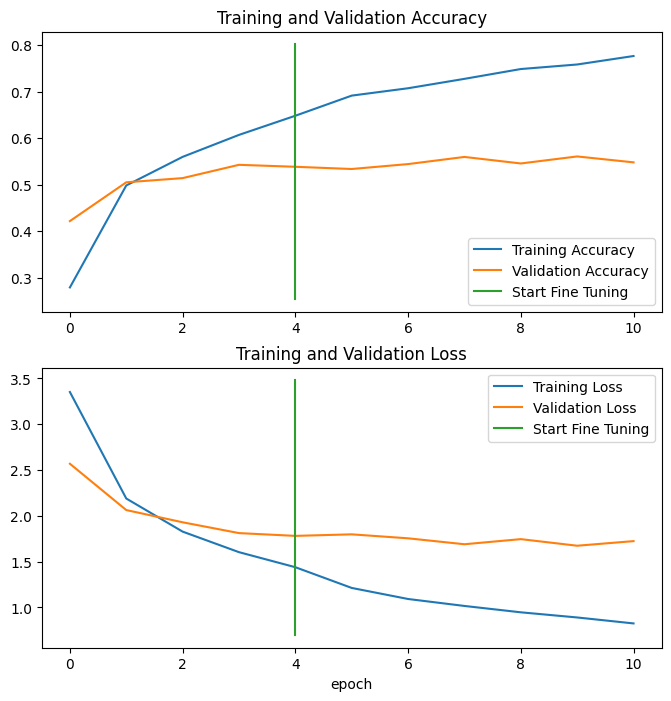

In [20]:
#Compare feature extraction model with fine tuning 
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5
                )

## Saving and loading our model
To use model in external application , we'need to save it and export it somewhere

In [21]:
# Save fine-tune model
model.save("101_food_classes_10_percent_saved_big_dog_model.h5")

In [22]:
#Load and evaluate saved model
loaded_model=tf.keras.models.load_model("101_food_classes_10_percent_saved_big_dog_model.h5")

In [23]:
#Evaluate loaded model
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 90s 112ms/step - loss: 1.4826 - accuracy: 0.6063


[1.482572078704834, 0.6062970161437988]

In [24]:
all_classes_10_percent_fine_tune_results

[1.482572078704834, 0.6062970161437988]

## Evaluating the performance of the big dog model across all different classes

In [25]:
import tensorflow as tf



In [26]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [27]:
#Load in save model
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [28]:
#Evaluate loaded model
result_downloaded_model=model.evaluate(test_data)
result_downloaded_model

790/790 [==============================] - 92s 115ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Make predictions with our trained model

In [29]:
#Make prediction with model
preds_probs=model.predict(test_data,verbose=1)# set verbose to see how long is left

790/790 [==============================] - 88s 109ms/step


In [30]:
#How many prediction are there
len(preds_probs)

25250

In [31]:
#Shape of our prediction
preds_probs.shape

(25250, 101)

In [32]:
#First 10 predictions
preds_probs[:10]

array([[5.9542160e-02, 3.5742075e-06, 4.1376811e-02, ..., 1.4138677e-09,
        8.3530897e-05, 3.0897621e-03],
       [9.6401668e-01, 1.3753217e-09, 8.4780529e-04, ..., 5.4287200e-05,
        7.8361909e-12, 9.8465447e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866934e-03, ..., 7.1891270e-07,
        5.4397680e-07, 4.0275925e-05],
       ...,
       [4.7313276e-01, 1.2931200e-07, 1.4805562e-03, ..., 5.9750088e-04,
        6.6968991e-05, 2.3469349e-05],
       [4.4571918e-02, 4.7265772e-07, 1.2258500e-01, ..., 6.3498710e-06,
        7.5318899e-06, 3.6778918e-03],
       [7.2438926e-01, 1.9249762e-09, 5.2311112e-05, ..., 1.2291385e-03,
        1.5792737e-09, 9.6395692e-05]], dtype=float32)

In [33]:
preds_probs[0]

array([5.9542160e-02, 3.5742075e-06, 4.1376811e-02, 1.0660594e-09,
       8.1614573e-09, 8.6640295e-09, 8.0927248e-07, 8.5652965e-07,
       1.9859086e-05, 8.0977907e-07, 3.1727856e-09, 9.8674184e-07,
       2.8532374e-04, 7.8049323e-10, 7.4230001e-04, 3.8916591e-05,
       6.4740543e-06, 2.4977323e-06, 3.7891234e-05, 2.0678381e-07,
       1.5538448e-05, 8.1507392e-07, 2.6230537e-06, 2.0010661e-07,
       8.3827911e-07, 5.4216075e-06, 3.7391133e-06, 1.3150480e-08,
       2.7761636e-03, 2.8052018e-05, 6.8562661e-10, 2.5574876e-05,
       1.6689036e-04, 7.6407564e-10, 4.0453140e-04, 1.3150731e-08,
       1.7957442e-06, 1.4448241e-06, 2.3062872e-02, 8.2466920e-07,
       8.5366071e-07, 1.7138707e-06, 7.0525489e-06, 1.8402233e-08,
       2.8553453e-07, 7.9483816e-06, 2.0681587e-06, 1.8525236e-07,
       3.3619891e-08, 3.1522606e-04, 1.0410910e-05, 8.5448841e-07,
       8.4741843e-01, 1.0555452e-05, 4.4094909e-07, 3.7404243e-05,
       3.5306384e-05, 3.2489097e-05, 6.7314919e-05, 1.2852612e

In [34]:
sum(preds_probs[0])

0.999999946541448

Our model outputs a prediction  probablity array (with N number of variables, whereN=no of classes) for each sample passed to the predict method

In [35]:
# We get one prediction probablity per class
print(f"No of prediction prbabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probablity sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest prediction probablity by the model for sample 0: {preds_probs[0].argmax()}")

No of prediction prbabilities for sample 0: 101
What prediction probablity sample 0 looks like:
 [5.9542160e-02 3.5742075e-06 4.1376811e-02 1.0660594e-09 8.1614573e-09
 8.6640295e-09 8.0927248e-07 8.5652965e-07 1.9859086e-05 8.0977907e-07
 3.1727856e-09 9.8674184e-07 2.8532374e-04 7.8049323e-10 7.4230001e-04
 3.8916591e-05 6.4740543e-06 2.4977323e-06 3.7891234e-05 2.0678381e-07
 1.5538448e-05 8.1507392e-07 2.6230537e-06 2.0010661e-07 8.3827911e-07
 5.4216075e-06 3.7391133e-06 1.3150480e-08 2.7761636e-03 2.8052018e-05
 6.8562661e-10 2.5574876e-05 1.6689036e-04 7.6407564e-10 4.0453140e-04
 1.3150731e-08 1.7957442e-06 1.4448241e-06 2.3062872e-02 8.2466920e-07
 8.5366071e-07 1.7138707e-06 7.0525489e-06 1.8402233e-08 2.8553453e-07
 7.9483816e-06 2.0681587e-06 1.8525236e-07 3.3619891e-08 3.1522606e-04
 1.0410910e-05 8.5448841e-07 8.4741843e-01 1.0555452e-05 4.4094909e-07
 3.7404243e-05 3.5306384e-05 3.2489097e-05 6.7314919e-05 1.2852612e-08
 2.6219754e-10 1.0318156e-05 8.5743937e-05 1.056993

In [36]:
test_data.class_names[52]

'gyoza'

In [37]:
#Get the pred classes of each label
pred_classes=preds_probs.argmax(axis=1)

#How do they look
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [38]:
len(pred_classes)

25250

Now we've got a prediction array of all our model's predictions , to evaluate them , we need to compare them to the original test dataset labels.

In [39]:
#To get our test labels we need to unravel our test_data BatchDataset
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [40]:
y_labels=[]
for images,labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
    

In [41]:
len(y_labels)

25250

## Evaluating model's prediction
One way to check that our model's prediction array is in same order as our test labels is to find the accuracy score

In [42]:
result_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [43]:
# Use sckit-learn accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,
                                y_pred=pred_classes
                               )
sklearn_accuracy

0.6077623762376237

In [44]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(result_downloaded_model[1],sklearn_accuracy)

True

# Let's make confusion matrix

In [45]:
from helper_functions import make_confusion_matrix

In [46]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [47]:
#Get list of class names
class_names=test_data.class_names

In [48]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)
     

## Let's keep the evaluation training going, time for classification report

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes
                           ))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [50]:
# Get a dictonary of classification report
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)

In [51]:
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [52]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Let's plot all of our classes F1-scores

In [53]:
#Create empty dictionary
class_f1_scores={}
#Loop through classification report dictionary items
for k ,v in classification_report_dict.items():
    if k=="accuracy": #stop once we get to accuracy
        break
    else:
        #Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]]=v["f1-score"]
        
class_f1_scores        

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [54]:
# Turn f1 score into dataframe
import pandas as pd
f1_scores=pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                       "f1-score":list(class_f1_scores.values())
                      }).sort_values("f1-score",ascending=False)

In [55]:
f1_scores.head()

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

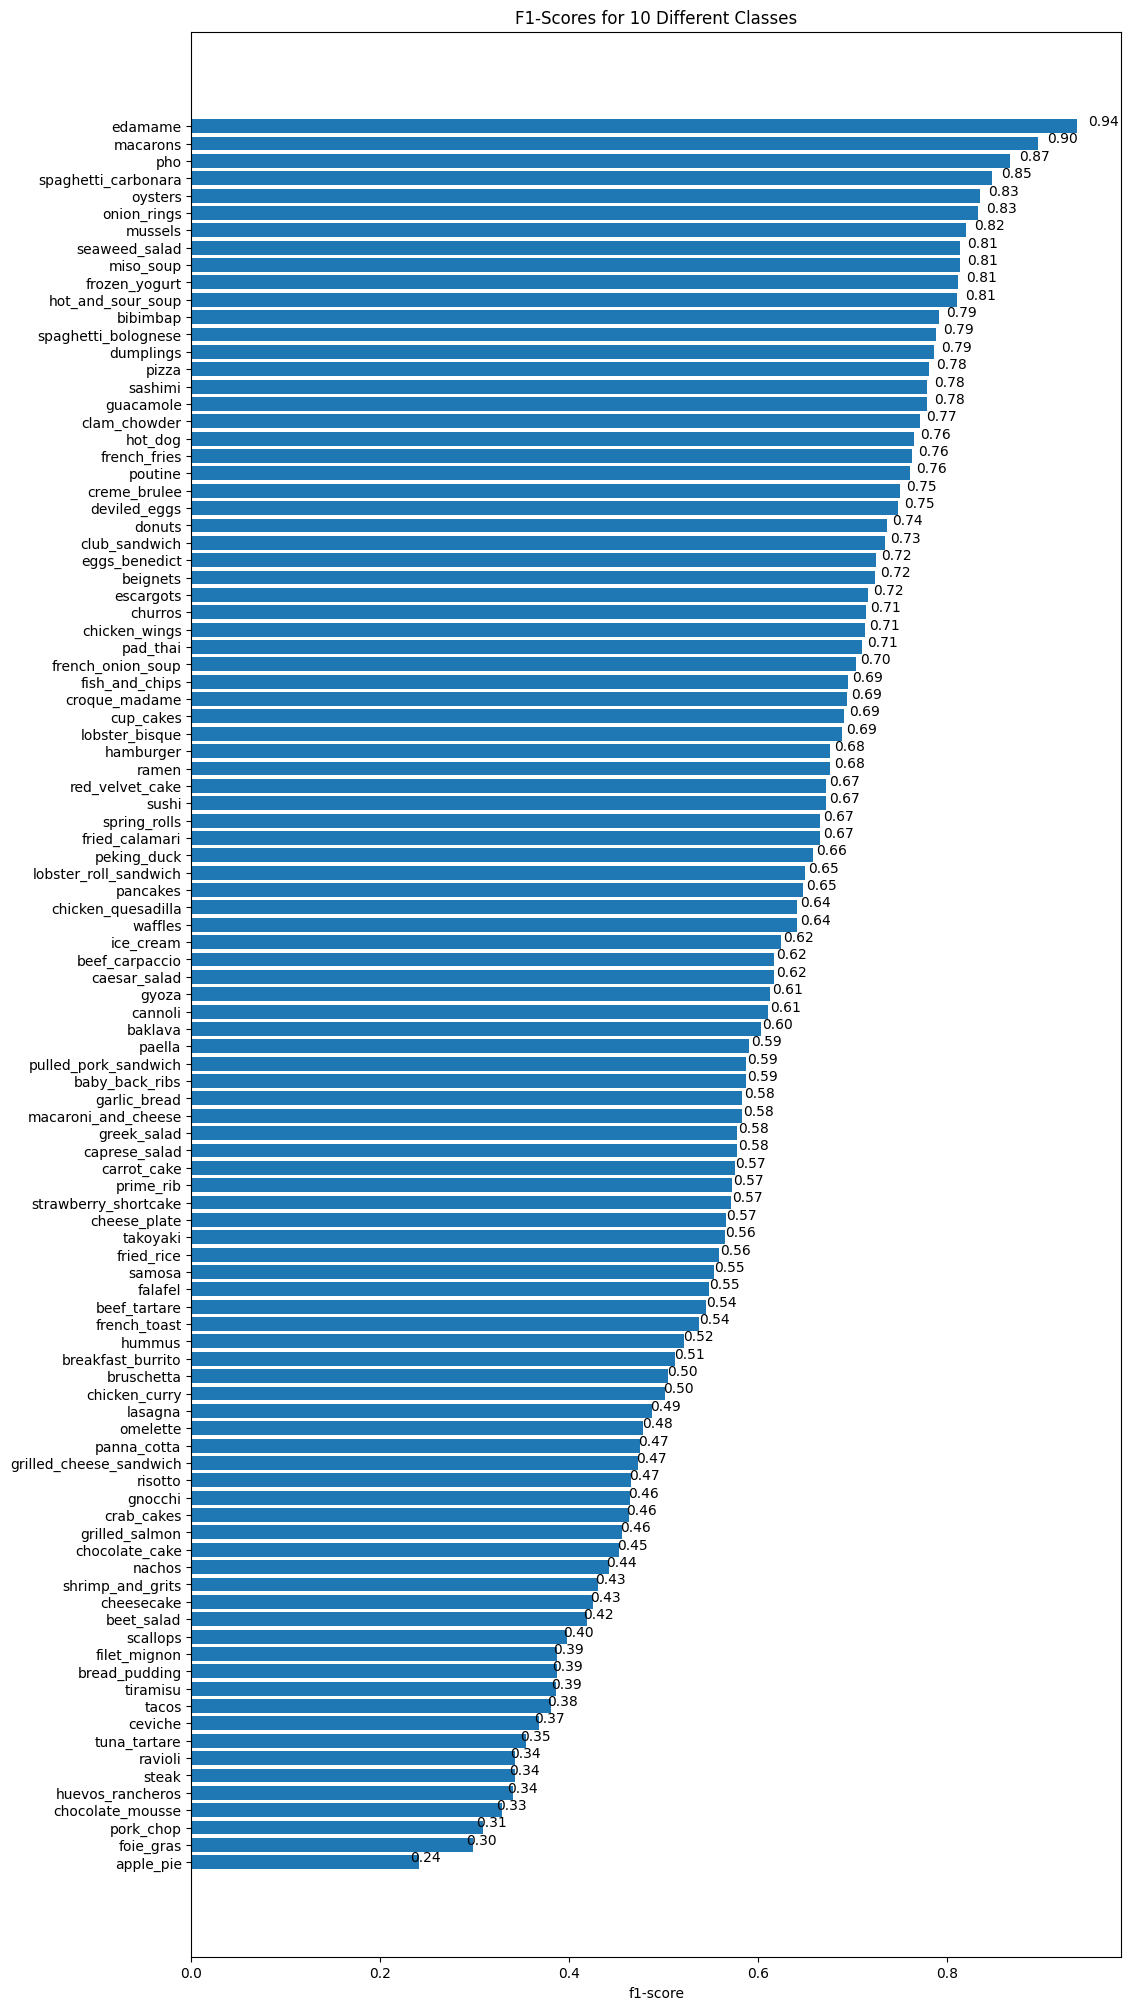

In [56]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing prediction on custom images
Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

* Read in a target image filepath using tf.io.read_file().
* Turn the image into a Tensor using tf.io.decode_image().
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using tf.image.resize().
* Scale the image to get all the pixel values between 0 & 1 if necessary.


In [57]:

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
     

Now we've got a function to load and prepare target images,let's now write some code to visualize images, their target label and our model's predictions.
Specially, we'll write some code to:
1. Load a few random images from the test dataset.
2. Make predictions on the loaded images
3. Plot the original images along with model's prediction , prediction probablity

In [58]:
train_data_all_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 0s 39ms/step


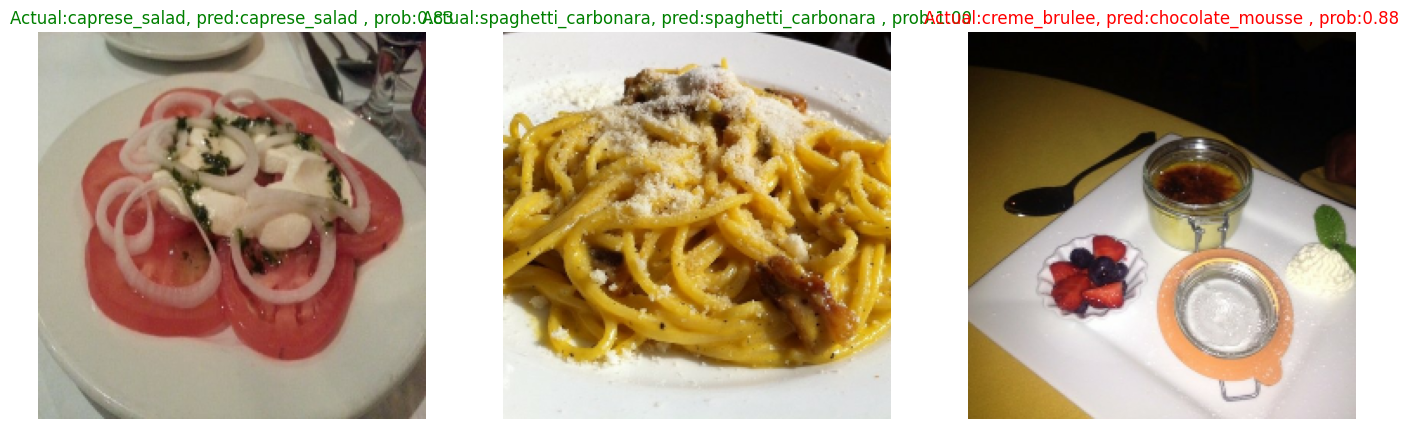

In [66]:
# Make oreds on a series of random images
import os
import random
plt.figure(figsize=(17,10))

for i in range(3):
    #Choose random image from random class
    class_name=random.choice(class_names)
    filename=random.choice(os.listdir(test_dir+"/"+class_name))
    filepath=test_dir+class_name+"/"+filename
    
    #Load the image and make prediction
    img=load_and_prep_image(filepath,scale=False)
#     print(img.shape)
    img_expanded=tf.expand_dims(img,axis=0)
#     print(img_expanded.shape)
    pred_prob=model.predict(tf.expand_dims(img,axis=0))#get prediction probablity array
    pred_class=class_names[pred_prob.argmax()] # Get highest prediction index
#     print(pred_prob)
#     print(pred_class)
    #Plot the images
    plt.subplot(1,3,i+1)
    plt.imshow(img/255.)
    if class_name==pred_class:#if predicted class matches truth class ,make txt green
        title_color="g"
    else:
        title_color="r"
    plt.title(f"Actual:{class_name}, pred:{pred_class} , prob:{pred_prob.max():.2f}",c=title_color) 
    plt.axis(False);

## Finding the most wrong predictions
To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file path in test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels,predicted classes(from our model), max prediction probablities.
3. Use our dataFrame to find all the wrong predictions (where the ground truth label doesn't match the predition)
4. Sort the DataFrame based on wrong prediction (have the highest probality prediction at the top)
5. Visualize the images with the highest prediction probablity but have wrong prediction.                                                       

In [60]:
#1.Get all of the image file paths in the test dataset
filepaths=[]
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]    

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [61]:
# 2. Create a Dataframe for different parameters
import pandas as pd
pred_df=pd.DataFrame({"img_path":filepaths,
                      "y_true":y_labels,
                      "y_pred":pred_classes,
                      "pred_conf":preds_probs.max(axis=1),#Get max prob value
                      "y_true_classname":[class_names[i] for i in y_labels],
                      "y_pred_clssname":[class_names[i] for i in pred_classes]
                     })

pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent\\test\\apple_pie...       0      52   
1      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100      16   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100      94   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   

       pred_conf y_true_classname       y_pred_clssname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501949          waffles  strawberry_shortcake  
25249   0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [62]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"]=pred_df["y_true"]==pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0      52   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0      79   

   pred_conf y_true_classname       y_pred_clssname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [63]:
# 4. Sort our DataFrame to have most wrong prediction at the top
top_100_wrong=pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent\\test\\scallops\...      87      29   
231    b'101_food_classes_10_percent\\test\\apple_pie...       0     100   
15359  b'101_food_classes_10_percent\\test\\lobster_r...      61      53   
23539  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
21400  b'101_food_classes_10_percent\\test\\samosa\\3...      85      92   
24540  b'101_food_classes_10_percent\\test\\tiramisu\...      98      83   
2511   b'101_food_classes_10_percent\\test\\bruschett...      10      61   
5574   b'101_food_classes_10_percent\\test\\chocolate...      22      21   
17855  b'101_food_classes_10_percent\\test\\paella\\2...      71      65   
23797  b'101_food_classes_10_percent\\test\\sushi\\16...      95      86   
18001  b'101_food_classes_10_percent\\test\\pancakes\...      72      67   
11642  b'101_food_classes_10_percent\\test\\garlic_br...      46      10   
10847  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   
23631  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
1155   b'101_food_classes_10_percent\\test\\beef_tart...       4       5   
10854  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   
23904  b'101_food_classes_10_percent\\test\\sushi\\33...      95      86   
7316   b'101_food_classes_10_percent\\test\\cup_cakes...      29      83   
13144  b'101_food_classes_10_percent\\test\\gyoza\\31...      52      92   
10880  b'101_food_classes_10_percent\\test\\fried_cal...      43      68   

       pred_conf       y_true_classname        y_pred_clssname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

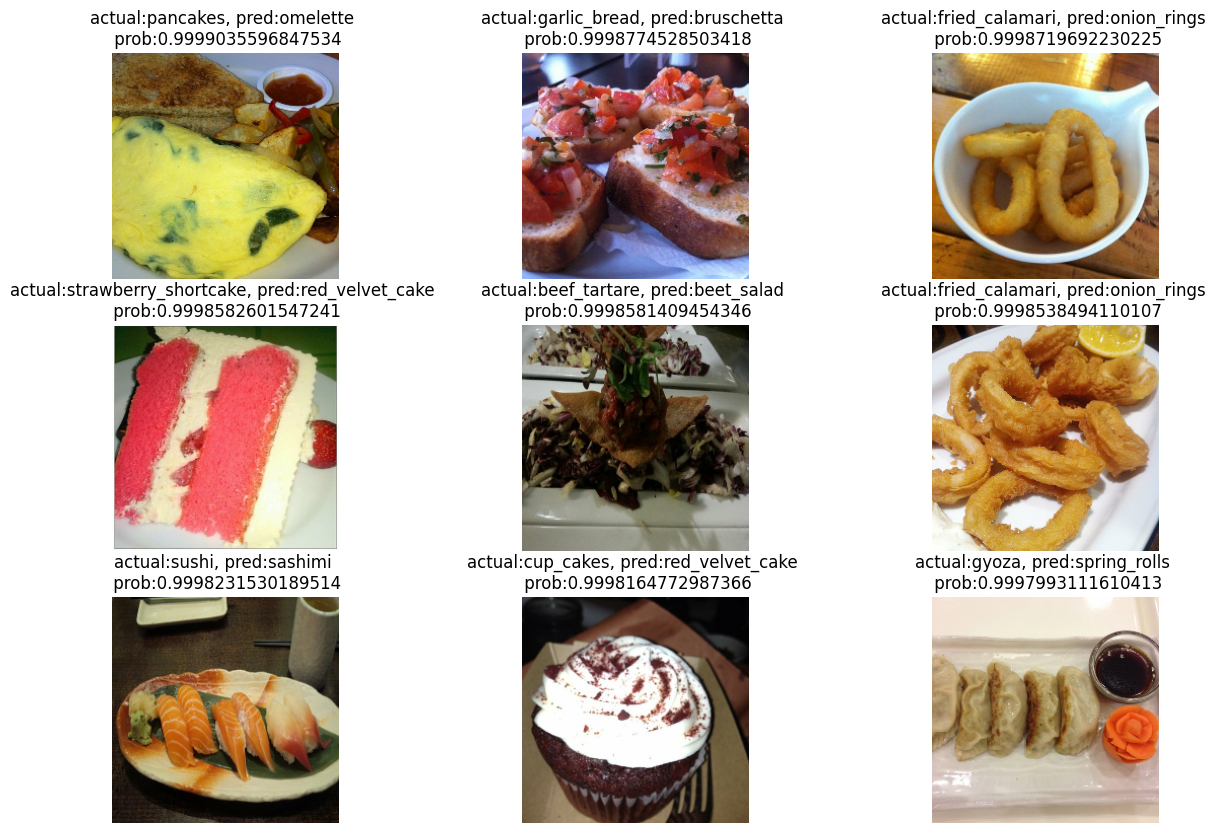

In [71]:
# 5. Visualize the test data samples which have the wrong prediction but high pred probability 
images_to_view=9
start_index=10
plt.figure(figsize=(15,10))

for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img=load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_=row#only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f"actual:{y_true_classname}, pred:{y_pred_classname} \n prob:{pred_prob}")
    plt.axis(False);

## Test out model on our own custom images

In [72]:
unzip_data("custom_food_images.zip")

In [73]:
# Get custom food images file path
custom_food_images=["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 35ms/step


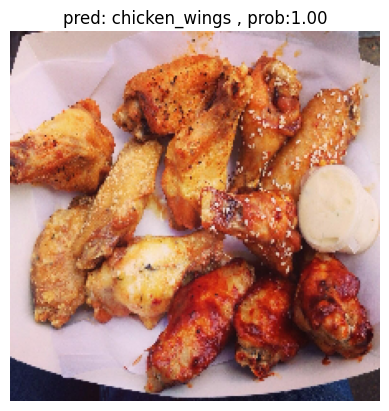

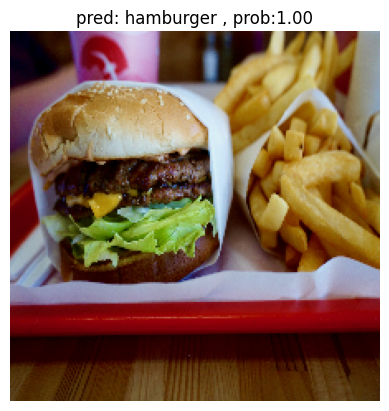

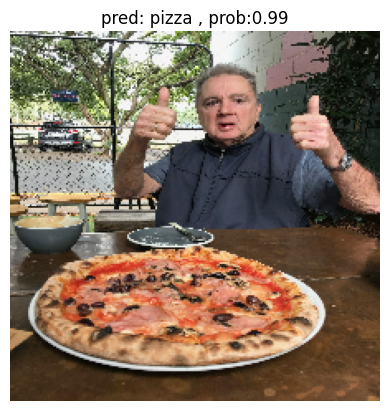

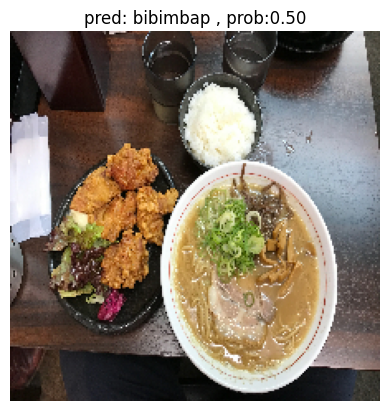

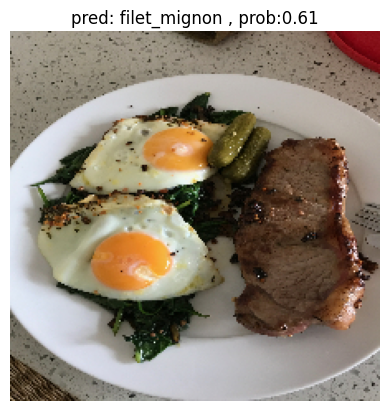

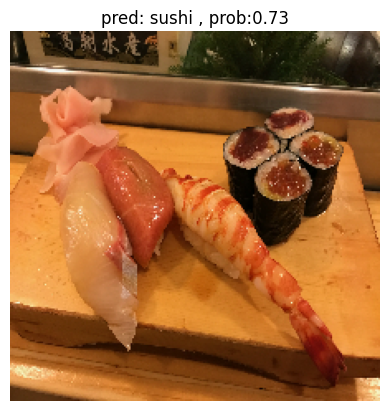

In [74]:
# Make prediction on and plot custom food images
for img in custom_food_images:
    img=load_and_prep_image(img,scale=False)
    pred_prob=model.predict(tf.expand_dims(img,axis=0))
    pred_class=class_names[pred_prob.argmax()]
    #Plot the appropriate info()
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class} , prob:{pred_prob.max():.2f}")
    plt.axis(False);

## Excersise 

Ques1: Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [3]:
import tensorflow as tf

In [5]:
train_dir,test_dir

('101_food_classes_10_percent/train/', '101_food_classes_10_percent/test/')

In [6]:
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                          label_mode="categorical",
                                                                          image_size=(224,224)
                                                                         )
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=(224,224),
                                                              shuffle=False
                                                             )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [24]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug=tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2)
],name="data_aug_layer")

In [11]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

In [14]:
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_aug(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(len(train_data_10_percent.class_names),activation="softmax")(x)
model_feature=tf.keras.Model(inputs,outputs)

In [15]:
model_feature.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=tf.keras.optimizers.Adam(),
 metrics=["accuracy"]   
)

In [16]:
history_feature=model_feature.fit(train_data_10_percent,
                                  epochs=10,
                                  validation_data=(test_data),
                                  validation_steps=int(.20*len(test_data))
                                 )

Epoch 1/10
237/237 [==============================] - 149s 566ms/step - loss: 3.2023 - accuracy: 0.3123 - val_loss: 2.4913 - val_accuracy: 0.4322
Epoch 2/10
237/237 [==============================] - 111s 468ms/step - loss: 1.9597 - accuracy: 0.5564 - val_loss: 2.0514 - val_accuracy: 0.4923
Epoch 3/10
237/237 [==============================] - 99s 419ms/step - loss: 1.5716 - accuracy: 0.6300 - val_loss: 1.9117 - val_accuracy: 0.5069
Epoch 4/10
237/237 [==============================] - 92s 387ms/step - loss: 1.3328 - accuracy: 0.6875 - val_loss: 1.7949 - val_accuracy: 0.5305
Epoch 5/10
237/237 [==============================] - 84s 352ms/step - loss: 1.1836 - accuracy: 0.7266 - val_loss: 1.7629 - val_accuracy: 0.5338
Epoch 6/10
237/237 [==============================] - 84s 355ms/step - loss: 1.0386 - accuracy: 0.7562 - val_loss: 1.7190 - val_accuracy: 0.5437
Epoch 7/10
237/237 [==============================] - 81s 341ms/step - loss: 0.9391 - accuracy: 0.7798 - val_loss: 1.7100 - val_

In [17]:
model_feature.evaluate(test_data)

790/790 [==============================] - 89s 113ms/step - loss: 1.4161 - accuracy: 0.6198


[1.4161314964294434, 0.6197623610496521]

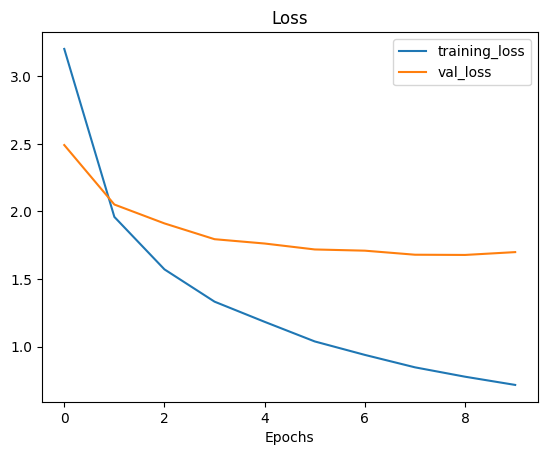

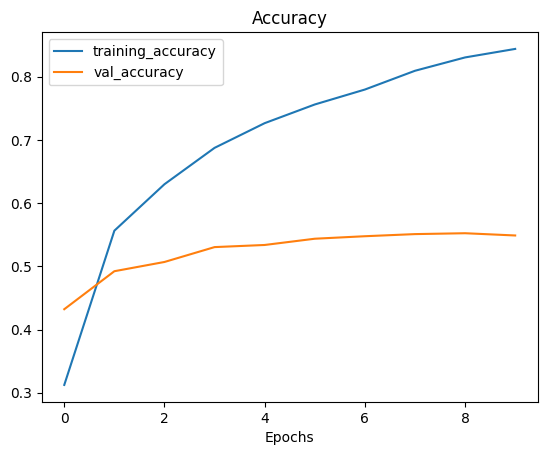

In [23]:
plot_loss_curves(history_feature)

In [25]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_aug(inputs)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(len(train_data_10_percent.class_names),activation="softmax")(x)
model_fine=tf.keras.Model(inputs,outputs)

In [26]:
model_fine.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=tf.keras.optimizers.Adam(),
 metrics=["accuracy"]   
)

In [27]:
history_fine_1=model_fine.fit(train_data_10_percent,
                                  epochs=5,
                                  validation_data=(test_data),
                                  validation_steps=int(.20*len(test_data))
                                 )

Epoch 1/5
237/237 [==============================] - 72s 281ms/step - loss: 3.3834 - accuracy: 0.2713 - val_loss: 2.6102 - val_accuracy: 0.4043
Epoch 2/5
237/237 [==============================] - 65s 276ms/step - loss: 2.2117 - accuracy: 0.4986 - val_loss: 2.1698 - val_accuracy: 0.4686
Epoch 3/5
237/237 [==============================] - 65s 274ms/step - loss: 1.8458 - accuracy: 0.5580 - val_loss: 2.0047 - val_accuracy: 0.4941
Epoch 4/5
237/237 [==============================] - 63s 264ms/step - loss: 1.6130 - accuracy: 0.6075 - val_loss: 1.9005 - val_accuracy: 0.5077
Epoch 5/5
237/237 [==============================] - 62s 260ms/step - loss: 1.4825 - accuracy: 0.6345 - val_loss: 1.8580 - val_accuracy: 0.5150


In [28]:
model_fine.evaluate(test_data)

790/790 [==============================] - 89s 112ms/step - loss: 1.5918 - accuracy: 0.5812


[1.5917822122573853, 0.5811881422996521]

In [30]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
    layer.trainable=False
    

In [32]:
model_fine.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(),
 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
 metrics=["accuracy"]   
)

In [33]:
fine_tune_epochs=10

In [34]:
history_fine_2=model_fine.fit(train_data_10_percent,
                                  epochs=fine_tune_epochs,
                                  validation_data=(test_data),
                                  validation_steps=int(.20*len(test_data)),
                                  initial_epoch=history_fine_1.epoch[-1]
                                 )

Epoch 5/10
237/237 [==============================] - 72s 275ms/step - loss: 1.2154 - accuracy: 0.6813 - val_loss: 1.7644 - val_accuracy: 0.5390
Epoch 6/10
237/237 [==============================] - 61s 259ms/step - loss: 1.1114 - accuracy: 0.7032 - val_loss: 1.7754 - val_accuracy: 0.5344
Epoch 7/10
237/237 [==============================] - 61s 258ms/step - loss: 1.0085 - accuracy: 0.7208 - val_loss: 1.7529 - val_accuracy: 0.5447
Epoch 8/10
237/237 [==============================] - 64s 270ms/step - loss: 0.9156 - accuracy: 0.7508 - val_loss: 1.7721 - val_accuracy: 0.5455
Epoch 9/10
237/237 [==============================] - 62s 263ms/step - loss: 0.8647 - accuracy: 0.7682 - val_loss: 1.7631 - val_accuracy: 0.5455
Epoch 10/10
237/237 [==============================] - 62s 262ms/step - loss: 0.8062 - accuracy: 0.7782 - val_loss: 1.7689 - val_accuracy: 0.5451


In [35]:
model_fine.evaluate(test_data)

790/790 [==============================] - 93s 117ms/step - loss: 1.5455 - accuracy: 0.5971


[1.5455032587051392, 0.5971089005470276]

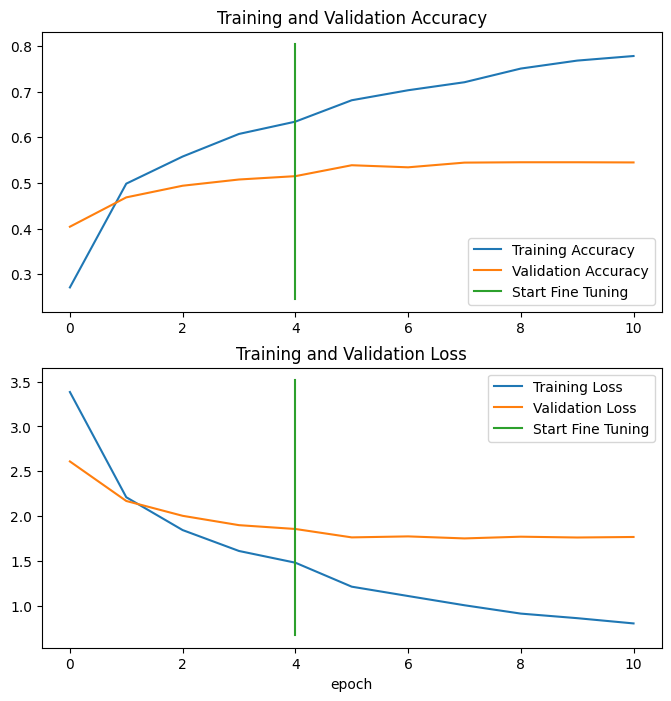

In [36]:
compare_historys(history_fine_1,history_fine_2)